# **Exploring the Depths of the Voluntary Carbon Market: An In-Depth Analysis of VCM and Registry Fees - III**

In [4]:
import os
import re
import locale
import requests
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gdp
import plotly.express as px
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from acr_fee_program import ACRFeeCalculator
from car_fee_program import CarCertificationFeesCalculator
from verra_fee_program import VCSCertificationFeesCalculator
from gold_standard_fee_program2 import GSCertificationFeesCalculator

# Set the global font to Times New Roman
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'


In [5]:
data = pd.read_csv('certifier_calculator.csv')

### **Introduction**
To validate countries in the Abatable Index a dataset with with all the existing countries a csv file was composed. and merged into the Abatable Index that's structured with only 40 countries

In [6]:
countries = pd.read_csv('countries_df.csv')
countries

name alpha-2 alpha-3  country-code     iso_3166-2   region   
0          Afghanistan      AF     AFG             4  ISO 3166-2:AF     Asia  \
1        Åland Islands      AX     ALA           248  ISO 3166-2:AX   Europe   
2              Albania      AL     ALB             8  ISO 3166-2:AL   Europe   
3              Algeria      DZ     DZA            12  ISO 3166-2:DZ   Africa   
4       American Samoa      AS     ASM            16  ISO 3166-2:AS  Oceania   
..                 ...     ...     ...           ...            ...      ...   
244  Wallis and Futuna      WF     WLF           876  ISO 3166-2:WF  Oceania   
245     Western Sahara      EH     ESH           732  ISO 3166-2:EH   Africa   
246              Yemen      YE     YEM           887  ISO 3166-2:YE     Asia   
247             Zambia      ZM     ZMB           894  ISO 3166-2:ZM   Africa   
248           Zimbabwe      ZW     ZWE           716  ISO 3166-2:ZW   Africa   

             sub-region intermediate-region  region-code  sub-region-code   
0         Southern Asia                 NaN        142.0             34.0  \
1       Northern Europe                 NaN        150.0            154.0   
2       Southern Europe                 NaN        150.0             39.0   
3       Northern Africa                 NaN          2.0             15.0   
4             Polynesia                 NaN          9.0             61.0   
..                  ...                 ...          ...              ...   
244           Polynesia                 NaN          9.0             61.0   
245     Northern Africa                 NaN          2.0             15.0   
246        Western Asia                 NaN        142.0            145.0   
247  Sub-Saharan Africa      Eastern Africa          2.0            202.0   
248  Sub-Saharan Africa      Eastern Africa          2.0            202.0   

     intermediate-region-code  
0                         NaN  
1                         NaN  
2                         NaN  
3                         NaN  
4                         NaN  
..                        ...  
244                       NaN  
245                       NaN  
246                       NaN  
247                      14.0  
248                      14.0  

[249 rows x 11 columns]

In [7]:
countries=countries[['name','region','sub-region']]
# Dictionary mapping old names to new names
name_changes = {
    "Lao People's Democratic Republic": 'Laos',  # Change the name of 'Åland Islands' to 'Aland Islands'
    'Bolivia (Plurinational State of)':'Bolivia',
     'Viet Nam':'Vietnam'# Change the name of 'Albania' to 'Republic of Albania'
}

# Replace the names in the 'name' column
countries['name'] = countries['name'].replace(name_changes)

# Print the updated DataFrame
countries

C:\Users\Francisco Bentes\AppData\Local\Temp\ipykernel_9012\3252248635.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countries['name'] = countries['name'].replace(name_changes)


name   region          sub-region
0          Afghanistan     Asia       Southern Asia
1        Åland Islands   Europe     Northern Europe
2              Albania   Europe     Southern Europe
3              Algeria   Africa     Northern Africa
4       American Samoa  Oceania           Polynesia
..                 ...      ...                 ...
244  Wallis and Futuna  Oceania           Polynesia
245     Western Sahara   Africa     Northern Africa
246              Yemen     Asia        Western Asia
247             Zambia   Africa  Sub-Saharan Africa
248           Zimbabwe   Africa  Sub-Saharan Africa

[249 rows x 3 columns]

In [8]:
file_url='https://www.abatable.com/vcm-investment-index/view#methodology'
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
}

response = requests.get(file_url, headers=headers)


In [9]:
soup = BeautifulSoup(response.content, 'html.parser')

In [10]:
# Find the first row of the table within the thead tag
header_row = soup.find('thead').find('tr')

# Extract text from th elements in the header row
header_columns = header_row.find_all('th')

# Extract text from specific columns (assuming you want the first three columns)
thead_texts = [column.get_text(separator=' ').replace('\n', '') for column in header_columns]


# Print or manipulate the extracted text as needed
print(thead_texts)

['Rank', 'Country', 'Overall score', 'Global carbon market readiness', 'Investment landscape', 'Climate, nature and people opportunity']


In [11]:
# Find all rows in the table
rows = soup.find('tbody').find_all('tr')

# Initialize an empty list to store extracted data
formatted_rows = []

# Iterate through rows and extract text from cells
for row in rows:
    # Extract text from all cells in the row
    cells = row.find_all(['th', 'td'])
    # Extract text from each cell and join them into a list
    row_data = [cell.get_text(strip=True) for cell in cells]
    # Append the row data to the formatted_rows list
    formatted_rows.append(row_data)

# Now, formatted_rows is a list of lists where each inner list represents a row of data
print(formatted_rows)

# Get the total number of rows (countries) in the data
number_of_countries = len(formatted_rows)
print("Number of countries:", number_of_countries)


[['1', 'Kenya', '78.0', '89', '66', '72'], ['2', 'Mexico', '78.0', '88', '64', '76'], ['3', 'Peru', '73.7', '81', '47', '85'], ['4', 'Ghana', '72.8', '83', '67', '63'], ['5', 'Malawi', '72.6', '88', '64', '56'], ['6', 'Ethiopia', '72.4', '84', '49', '75'], ['7', 'Cambodia', '72.0', '81', '61', '68'], ['8', 'Bangladesh', '71.3', '82', '55', '69'], ['9', 'Indonesia', '69.3', '57', '62', '93'], ['10', 'Thailand', '68.5', '65', '65', '76'], ['11', 'Mongolia', '67.3', '82', '75', '40'], ['12', 'Viet Nam', '67.0', '66', '74', '63'], ['13', 'Colombia', '66.6', '60', '59', '84'], ['14', 'Nigeria', '65.3', '60', '50', '86'], ['15', 'Madagascar', '62.9', '58', '60', '72'], ['16', 'Nepal', '62.7', '59', '66', '65'], ['17', 'Chile', '62.5', '58', '79', '56'], ['18', 'Uruguay', '62.0', '67', '91', '30'], ['19', 'Guatemala', '61.9', '58', '60', '69'], ['20', 'Uganda', '61.8', '63', '57', '64'], ['21', 'Myanmar', '61.6', '75', '15', '81'], ['22', 'Mozambique', '61.5', '58', '53', '73'], ['23', 'Seneg

In [12]:

# Convert formatted_rows to DataFrame
df = pd.DataFrame(formatted_rows, columns=thead_texts)

# Print the DataFrame
# Dictionary mapping old names to new names
name_changes = {
    "Lao PDR": 'Laos',  # Change the name of 'Åland Islands' to 'Aland Islands'
    'Dominican Rep.':'Dominican Republic' ,
    'Viet Nam':'Vietnam'# Change the name of 'Albania' to 'Republic of Albania'
}

# Replace the names in the 'name' column
df['Country'] = df['Country'].replace(name_changes)

# Print the updated DataFrame
countries

name   region          sub-region
0          Afghanistan     Asia       Southern Asia
1        Åland Islands   Europe     Northern Europe
2              Albania   Europe     Southern Europe
3              Algeria   Africa     Northern Africa
4       American Samoa  Oceania           Polynesia
..                 ...      ...                 ...
244  Wallis and Futuna  Oceania           Polynesia
245     Western Sahara   Africa     Northern Africa
246              Yemen     Asia        Western Asia
247             Zambia   Africa  Sub-Saharan Africa
248           Zimbabwe   Africa  Sub-Saharan Africa

[249 rows x 3 columns]

In [13]:
merged_df = df.merge(countries, left_on='Country', right_on='name', how='left')
merged_df=merged_df[['Rank','Country','region','sub-region','Overall score','Global carbon market readiness','Investment landscape','Climate, nature and people opportunity']]

In [14]:
merged_df.to_csv('index_data.csv',index=False)

# **Abatable: VCM INDEX**

## **Data Preprocessing**

In [15]:
index=pd.read_csv('index_data.csv')

In [16]:
ma=index.merge(data, left_on='Country',right_on='Country', how='left')
ma.columns

Index(['Rank', 'Country', 'region', 'sub-region', 'Overall score',
       'Global carbon market readiness', 'Investment landscape',
       'Climate, nature and people opportunity', 'Project ID', 'Project Name',
       'Voluntary Registry', 'ARB Project', 'First Year of Project',
       'project_timeline', 'Voluntary Status', 'Project Developer',
       'Total Credits Issued', 'Total Credits Retired',
       'Total Credits Remaining', 'Estimated Annual Emission Reductions',
       'Scope', 'Type', 'Reduction / Removal', 'Methodology / Protocol',
       'Region', 'Issuance Fees', 'Fixed Costs', 'Total Fixed Fees',
       'Total Issuance Fees', 'Total Fees', 'VVB Fees', 'unitary_cost',
       'percentage_of_fixed', 'Fixed Fees Per Credit %'],
      dtype='object')

In [17]:
ma.Country.unique()

array(['Kenya', 'Mexico', 'Peru', 'Ghana', 'Malawi', 'Ethiopia',
       'Cambodia', 'Bangladesh', 'Indonesia', 'Thailand', 'Mongolia',
       'Vietnam', 'Colombia', 'Nigeria', 'Madagascar', 'Nepal', 'Chile',
       'Uruguay', 'Guatemala', 'Uganda', 'Myanmar', 'Mozambique',
       'Senegal', 'Zambia', 'Honduras', 'Rwanda', 'Brazil', 'Philippines',
       'India', 'Laos', 'Papua New Guinea', 'Costa Rica', 'Panama',
       'Dominican Republic', 'Ecuador', 'Cameroon', 'South Africa',
       'China', 'Pakistan', 'Bolivia'], dtype=object)

In [18]:
# Assuming index.Country and data.Country are your arrays
common_countries = np.intersect1d(index.Country.unique(), data.Country.unique())

# Print the common countries
print(common_countries)

['Bangladesh' 'Bolivia' 'Brazil' 'Cambodia' 'Cameroon' 'Chile' 'China'
 'Colombia' 'Costa Rica' 'Dominican Republic' 'Ecuador' 'Ethiopia' 'Ghana'
 'Guatemala' 'Honduras' 'India' 'Indonesia' 'Kenya' 'Laos' 'Madagascar'
 'Malawi' 'Mexico' 'Mongolia' 'Mozambique' 'Myanmar' 'Nepal' 'Nigeria'
 'Pakistan' 'Panama' 'Papua New Guinea' 'Peru' 'Philippines' 'Rwanda'
 'Senegal' 'South Africa' 'Thailand' 'Uganda' 'Uruguay' 'Vietnam' 'Zambia']


In [19]:
# Assuming index.Country and data.Country are your arrays
countries_in_index_not_in_data = np.setdiff1d(index.Country.unique(), data.Country.unique())

# Print the countries in index.Country but not in data.Country
print(countries_in_index_not_in_data)

[]


In [20]:
ma.columns

Index(['Rank', 'Country', 'region', 'sub-region', 'Overall score',
       'Global carbon market readiness', 'Investment landscape',
       'Climate, nature and people opportunity', 'Project ID', 'Project Name',
       'Voluntary Registry', 'ARB Project', 'First Year of Project',
       'project_timeline', 'Voluntary Status', 'Project Developer',
       'Total Credits Issued', 'Total Credits Retired',
       'Total Credits Remaining', 'Estimated Annual Emission Reductions',
       'Scope', 'Type', 'Reduction / Removal', 'Methodology / Protocol',
       'Region', 'Issuance Fees', 'Fixed Costs', 'Total Fixed Fees',
       'Total Issuance Fees', 'Total Fees', 'VVB Fees', 'unitary_cost',
       'percentage_of_fixed', 'Fixed Fees Per Credit %'],
      dtype='object')

## **Data Analysis**

In [21]:
index = ma.groupby(['Country', 'Region', 'Type','Voluntary Registry']).agg({
    'Project ID': 'count',
    'Total Credits Issued': 'sum',
    'First Year of Project': 'max', 
    'Rank': 'max',
    'Global carbon market readiness': 'max',
    'Investment landscape': 'max',
    'Climate, nature and people opportunity': 'max',
    'unitary_cost': 'mean'
}).reset_index().sort_values('Rank')

In [22]:
index=index[index['Region'].isin(['Europe', 'South America', 'North Africa', 'Sub Saharan Africa'])]

In [23]:
index

Country              Region                         Type   
191    Kenya  Sub Saharan Africa      Sustainable Agriculture  \
190    Kenya  Sub Saharan Africa               Solar Lighting   
189    Kenya  Sub Saharan Africa                        REDD+   
188    Kenya  Sub Saharan Africa                   Geothermal   
187    Kenya  Sub Saharan Africa                   Cookstoves   
..       ...                 ...                          ...   
4    Bolivia       South America  Afforestation/Reforestation   
8    Bolivia       South America                        REDD+   
7    Bolivia       South America                   Hydropower   
6    Bolivia       South America               Fuel Switching   
5    Bolivia       South America                   Cookstoves   

    Voluntary Registry  Project ID  Total Credits Issued   
191                VCS           1                325825  \
190               GOLD           3                201348   
189                VCS           3              24102676   
188                VCS           1                244798   
187                VCS           5                652261   
..                 ...         ...                   ...   
4                 GOLD           1                133691   
8                  VCS           1                 55400   
7                  VCS           1                 50000   
6                  ACR           1                  1138   
5                 GOLD           3                 40895   

     First Year of Project  Rank  Global carbon market readiness   
191                   2012     1                              89  \
190                   2017     1                              89   
189                   2013     1                              89   
188                   2008     1                              89   
187                   2020     1                              89   
..                     ...   ...                             ...   
4                     2008    40                              37   
8                     2012    40                              37   
7                     2012    40                              37   
6                     2005    40                              37   
5                     2014    40                              37   

     Investment landscape  Climate, nature and people opportunity   
191                    66                                      72  \
190                    66                                      72   
189                    66                                      72   
188                    66                                      72   
187                    66                                      72   
..                    ...                                     ...   
4                      56                                      73   
8                      56                                      73   
7                      56                                      73   
6                      56                                      73   
5                      56                                      73   

     unitary_cost  
191      0.255244  
190      1.301154  
189      0.205836  
188      0.249020  
187      0.393163  
..            ...  
4        0.661395  
8        0.362455  
7        0.510000  
6      111.312162  
5        6.086976  

[150 rows x 12 columns]

In [24]:
project_type_distribution = index.groupby(['Country', 'Region', 'Type'])['Project ID'].count().reset_index()
print(project_type_distribution)


     Country              Region                         Type  Project ID
0    Bolivia       South America  Afforestation/Reforestation           1
1    Bolivia       South America                   Cookstoves           1
2    Bolivia       South America               Fuel Switching           1
3    Bolivia       South America                   Hydropower           1
4    Bolivia       South America                        REDD+           1
..       ...                 ...                          ...         ...
120   Zambia  Sub Saharan Africa                  Clean Water           1
121   Zambia  Sub Saharan Africa                   Cookstoves           2
122   Zambia  Sub Saharan Africa                   Hydropower           1
123   Zambia  Sub Saharan Africa                        REDD+           1
124   Zambia  Sub Saharan Africa               Solar Lighting           1

[125 rows x 4 columns]


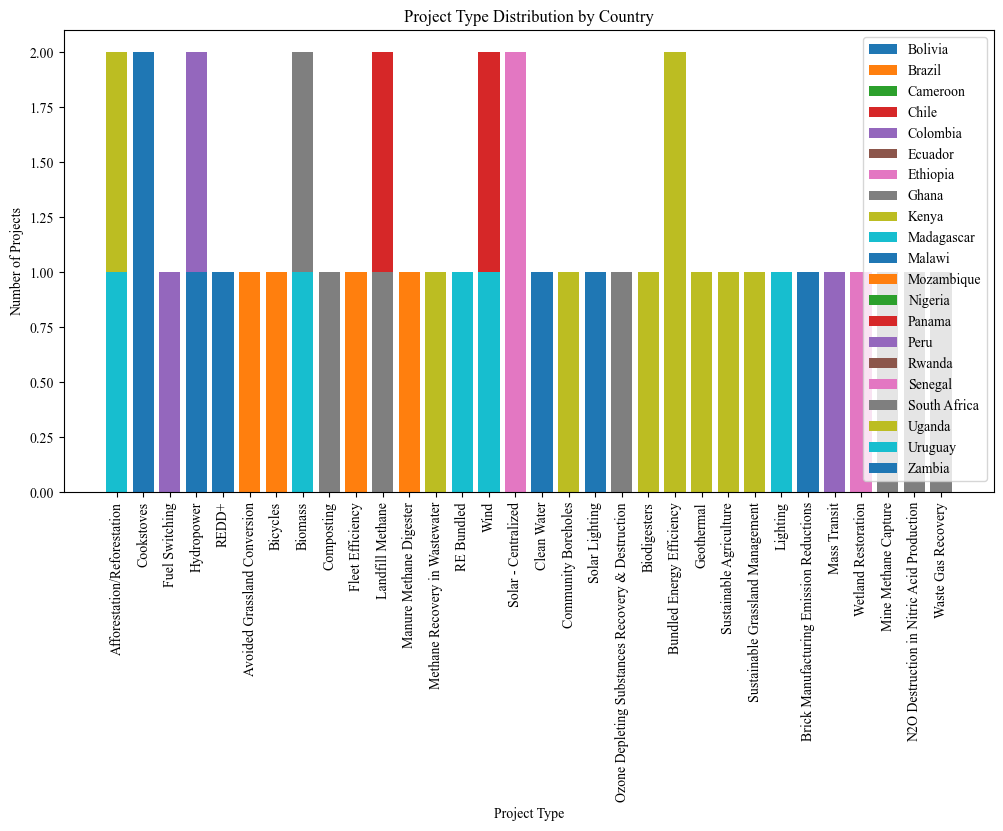

In [25]:
plt.figure(figsize=(12, 6))
for country in project_type_distribution['Country'].unique():
    country_data = project_type_distribution[project_type_distribution['Country'] == country]
    plt.bar(country_data['Type'], country_data['Project ID'], label=country)

plt.xlabel('Project Type')
plt.ylabel('Number of Projects')
plt.title('Project Type Distribution by Country')
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [26]:
total_credits_by_registry = index.groupby('Voluntary Registry')['Total Credits Issued'].sum().reset_index()
print(total_credits_by_registry)


  Voluntary Registry  Total Credits Issued
0                ACR               4579194
1               GOLD              66684041
2                VCS             326997975


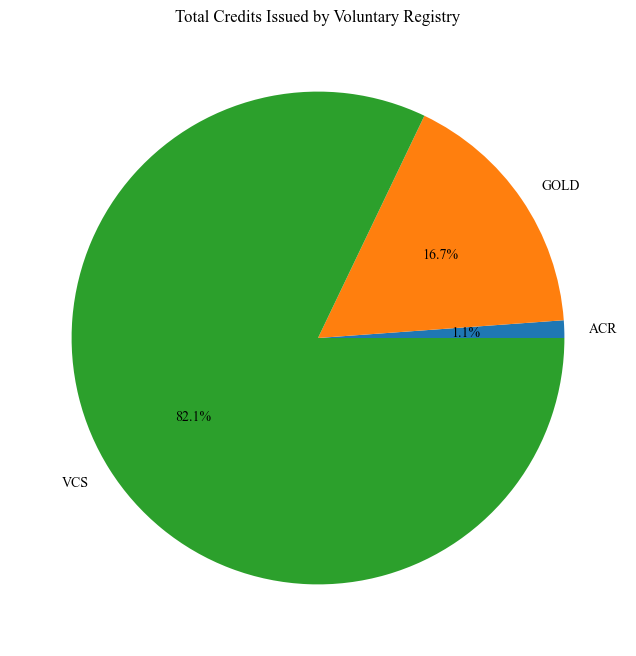

In [27]:
plt.figure(figsize=(8, 8))
plt.pie(total_credits_by_registry['Total Credits Issued'], labels=total_credits_by_registry['Voluntary Registry'], autopct='%1.1f%%')
plt.title('Total Credits Issued by Voluntary Registry')
plt.show()


In [28]:
average_cost_by_type = index.groupby('Type')['unitary_cost'].mean().reset_index()
print(average_cost_by_type)


                                                 Type  unitary_cost
0                         Afforestation/Reforestation      4.457296
1                        Avoided Grassland Conversion      0.245773
2                                            Bicycles      5.496195
3                                        Biodigesters      1.223780
4                                             Biomass      1.053509
5             Brick Manufacturing Emission Reductions      1.645415
6                           Bundled Energy Efficiency      5.752169
7                                         Clean Water      3.030434
8                                 Community Boreholes      1.861870
9                                          Composting      1.579817
10                                         Cookstoves     13.591764
11                                   Fleet Efficiency      0.810191
12                                     Fuel Switching     37.438220
13                                         Geoth

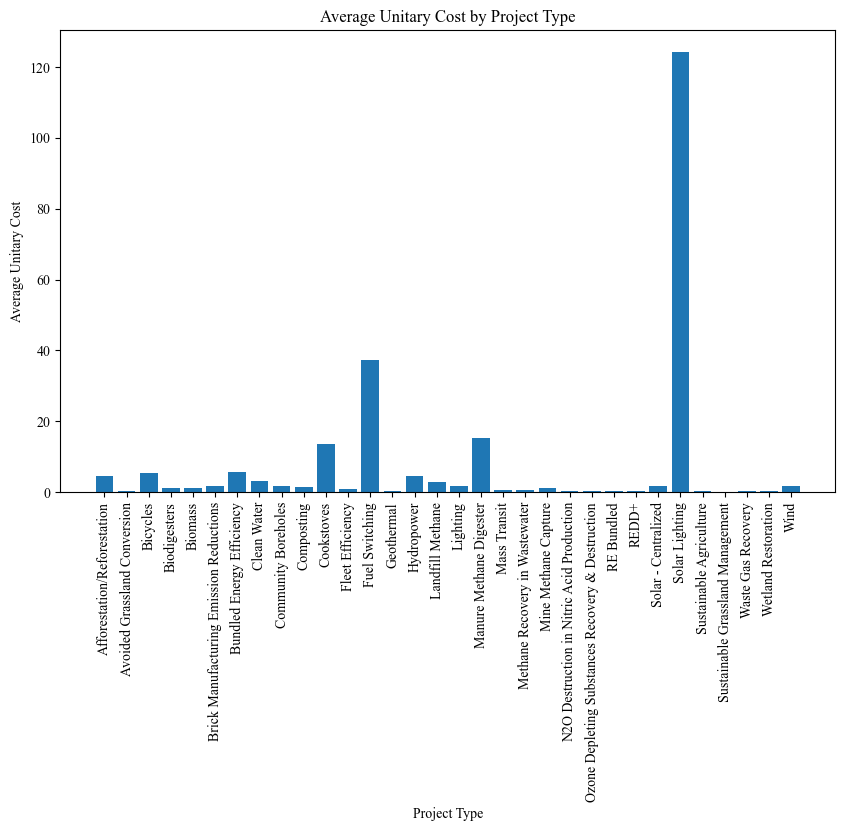

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(average_cost_by_type['Type'], average_cost_by_type['unitary_cost'])
plt.xlabel('Project Type')
plt.ylabel('Average Unitary Cost')
plt.title('Average Unitary Cost by Project Type')
plt.xticks(rotation=90)
plt.show()


      Country              Region                         Type   
259      Peru       South America                        REDD+  \
26     Brazil       South America                        REDD+   
87   Colombia       South America                        REDD+   
189     Kenya  Sub Saharan Africa                        REDD+   
20     Brazil       South America                   Hydropower   
309   Uruguay       South America  Afforestation/Reforestation   
186     Kenya  Sub Saharan Africa                   Cookstoves   
328    Zambia  Sub Saharan Africa                        REDD+   
304    Uganda  Sub Saharan Africa                   Cookstoves   
101  Ethiopia  Sub Saharan Africa                        REDD+   
106     Ghana  Sub Saharan Africa                   Cookstoves   
14     Brazil       South America                      Biomass   

    Voluntary Registry  Total Credits Issued  
259                VCS              86542868  
26                 VCS              67326018  


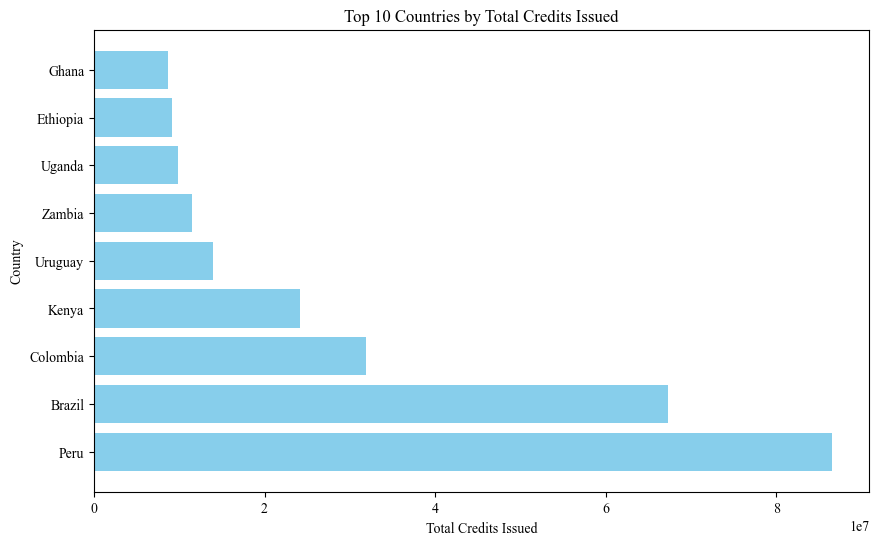

In [30]:
top_projects = index.nlargest(12, 'Total Credits Issued')
print(top_projects[['Country', 'Region', 'Type', 'Voluntary Registry', 'Total Credits Issued']])
plt.figure(figsize=(10, 6))
plt.barh(top_projects['Country'], top_projects['Total Credits Issued'], color='skyblue')
plt.xlabel('Total Credits Issued')
plt.ylabel('Country')
plt.title('Top 10 Countries by Total Credits Issued')
plt.show()


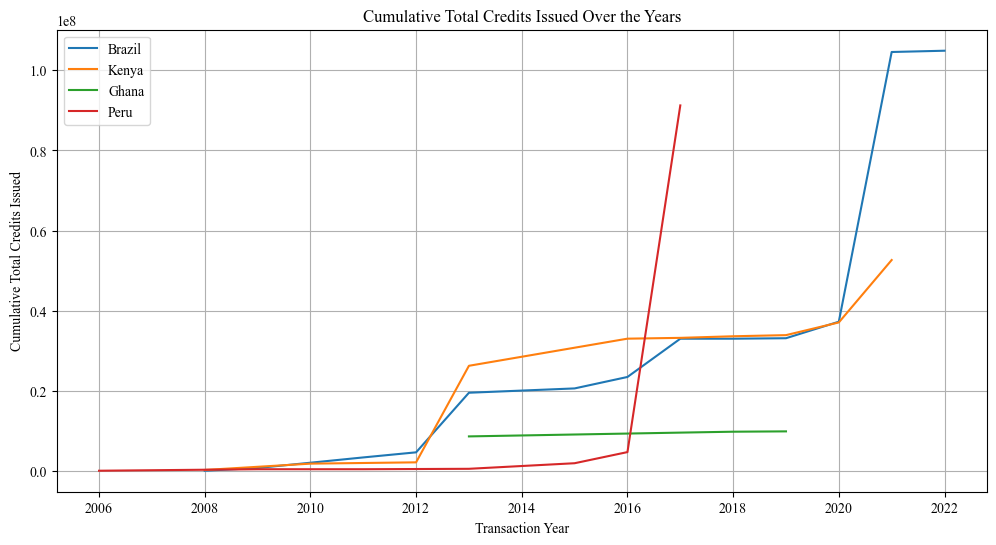

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'index' with columns: 'Country', 'Transaction Year', 'Total Credits Issued'

# Select data for Brazil, Kenya, Ghana, and Peru
selected_countries = ['Brazil', 'Kenya', 'Ghana', 'Peru']
selected_data = index[index['Country'].isin(selected_countries)]

# Group by 'Country' and 'Transaction Year' and calculate the cumulative sum of total credits issued
cumulative_credits_by_country_year = selected_data.groupby(['Country', 'First Year of Project'])['Total Credits Issued'].sum().groupby(level=0).cumsum().reset_index()

# Create a line chart for the cumulative sum of each country
plt.figure(figsize=(12, 6))
for country in selected_countries:
    country_data = cumulative_credits_by_country_year[cumulative_credits_by_country_year['Country'] == country]
    plt.plot(country_data['First Year of Project'], country_data['Total Credits Issued'], label=country)

# Add labels and a legend
plt.xlabel('Transaction Year')
plt.ylabel('Cumulative Total Credits Issued')
plt.title('Cumulative Total Credits Issued Over the Years')
plt.legend()
plt.grid(True)
plt.show()


### boxplot outliers

       Global carbon market readiness  Investment landscape   
count                      150.000000            150.000000  \
mean                        60.346667             60.980000   
std                         18.739825             10.378391   
min                         28.000000             47.000000   
25%                         41.000000             53.000000   
50%                         58.000000             60.000000   
75%                         81.000000             66.000000   
max                         89.000000             91.000000   

       Climate, nature and people opportunity  
count                              150.000000  
mean                                71.366667  
std                                 13.809061  
min                                 30.000000  
25%                                 61.000000  
50%                                 72.000000  
75%                                 83.500000  
max                                 91.000000  


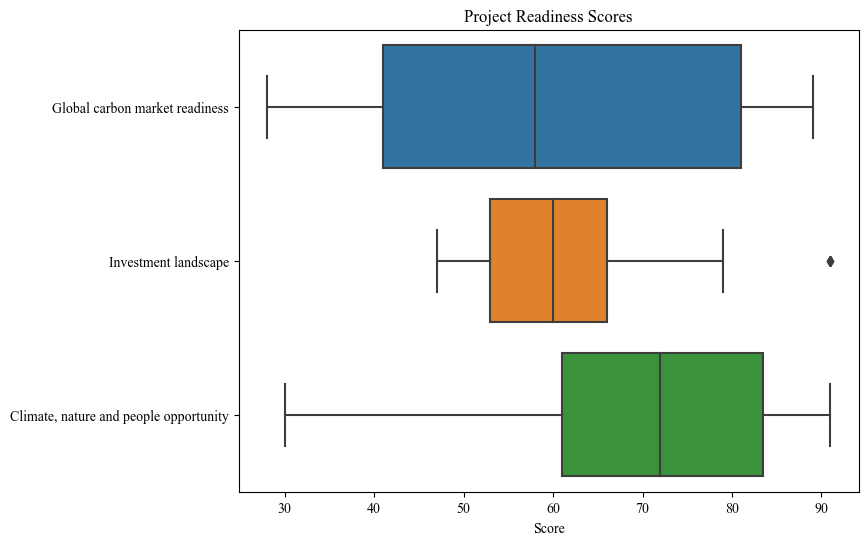

In [75]:
readiness_scores = index[['Global carbon market readiness', 'Investment landscape', 'Climate, nature and people opportunity']]
print(readiness_scores.describe())
plt.figure(figsize=(8, 6))
sns.boxplot(data=readiness_scores, orient='h')
plt.xlabel('Score')
plt.title('Project Readiness Scores')
stats = readiness_scores.describe()


In [84]:
index[index['Investment landscape'] == 91]

Country         Region                         Type Voluntary Registry   
310  Uruguay  South America                      Biomass                VCS  \
309  Uruguay  South America  Afforestation/Reforestation                VCS   
312  Uruguay  South America                         Wind                VCS   
311  Uruguay  South America                   RE Bundled                VCS   

     Project ID  Total Credits Issued  First Year of Project  Rank   
310           1                 73743                   2008    18  \
309           5              13895644                   2013    18   
312           4               1359114                   2016    18   
311           1                729418                   2014    18   

     Global carbon market readiness  Investment landscape   
310                              67                    91  \
309                              67                    91   
312                              67                    91   
311                              67                    91   

     Climate, nature and people opportunity  unitary_cost  Average Score  
310                                      30      0.400503      62.666667  
309                                      30      0.224982      62.666667  
312                                      30      0.460381      62.666667  
311                                      30      0.226048      62.666667

### Average scores by country

In [33]:
index['Average Score'] = (index['Global carbon market readiness'] + index['Investment landscape'] + index['Climate, nature and people opportunity']) /3

In [34]:
best_country = index[['Country', 'Type', 'Voluntary Registry', 'Average Score']]

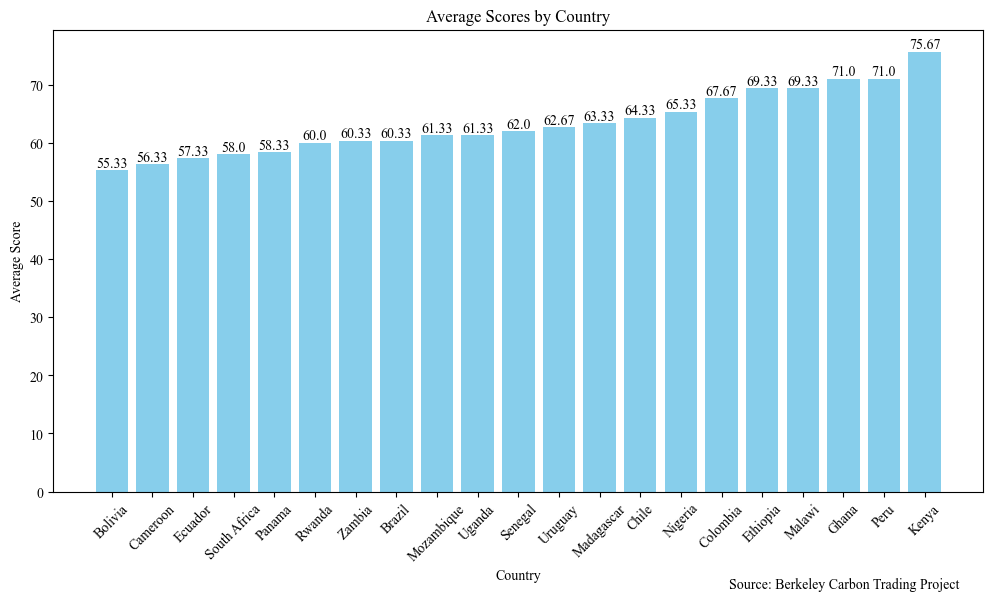

In [87]:
average_scores_by_country = index.groupby('Country')['Average Score'].mean().reset_index()

# Sort the DataFrame by 'Average Score' in descending order
average_scores_by_country = average_scores_by_country.sort_values(by='Average Score', ascending=True)

plt.figure(figsize=(12, 6))
bars = plt.bar(average_scores_by_country['Country'], average_scores_by_country['Average Score'], color='skyblue')
plt.xlabel('Country')
plt.ylabel('Average Score')
plt.title('Average Scores by Country')
plt.text(0.85, -0.2, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
plt.xticks(rotation=45)

# Adding numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

In [55]:
import matplotlib.pyplot as plt

# Assuming 'index' DataFrame contains 'Country', 'Average Score', and 'Region' columns

# Group data by 'Region' and calculate the average score
average_scores_by_region = index.groupby('Region')['Average Score'].mean().reset_index()


In [56]:
average_scores_by_region

Region  Average Score
0       South America      63.134503
1  Sub Saharan Africa      64.903226

In [ ]:

# Filter the data for African and South American regions
africa_average_score = average_scores_by_region[average_scores_by_region['Region'] == 'Africa']['Average Score'].values[0]
south_america_average_score = average_scores_by_region[average_scores_by_region['Region'] == 'South America']['Average Score'].values[0]

print(f"Average score for African countries: {africa_average_score}")
print(f"Average score for South American countries: {south_america_average_score}")


In [36]:
average_scores_by_country

Country  Average Score
0        Bolivia      55.333333
2       Cameroon      56.333333
5        Ecuador      57.333333
17  South Africa      58.000000
13        Panama      58.333333
15        Rwanda      60.000000
20        Zambia      60.333333
1         Brazil      60.333333
11    Mozambique      61.333333
18        Uganda      61.333333
16       Senegal      62.000000
19       Uruguay      62.666667
9     Madagascar      63.333333
3          Chile      64.333333
12       Nigeria      65.333333
4       Colombia      67.666667
6       Ethiopia      69.333333
10        Malawi      69.333333
7          Ghana      71.000000
14          Peru      71.000000
8          Kenya      75.666667

### African and south america scores for each index

In [68]:
# Assuming 'index' DataFrame contains columns: 'Country', 'Global carbon market readiness', 'Investment landscape', 'Climate, nature and people opportunity', and 'Region'

# Filter data for African and South American regions
african_countries = index[index['Region'] == 'Sub Saharan Africa']
south_american_countries = index[index['Region'] == 'South America']

# Calculate average scores for each index in African countries
africa_average_scores = african_countries.groupby('Region')[['Global carbon market readiness','Investment landscape', 'Climate, nature and people opportunity']].mean()
# Calculate average scores for each index in South American countries
south_america_average_scores = south_american_countries.groupby('Region')[['Global carbon market readiness', 'Investment landscape', 'Climate, nature and people opportunity']].mean()

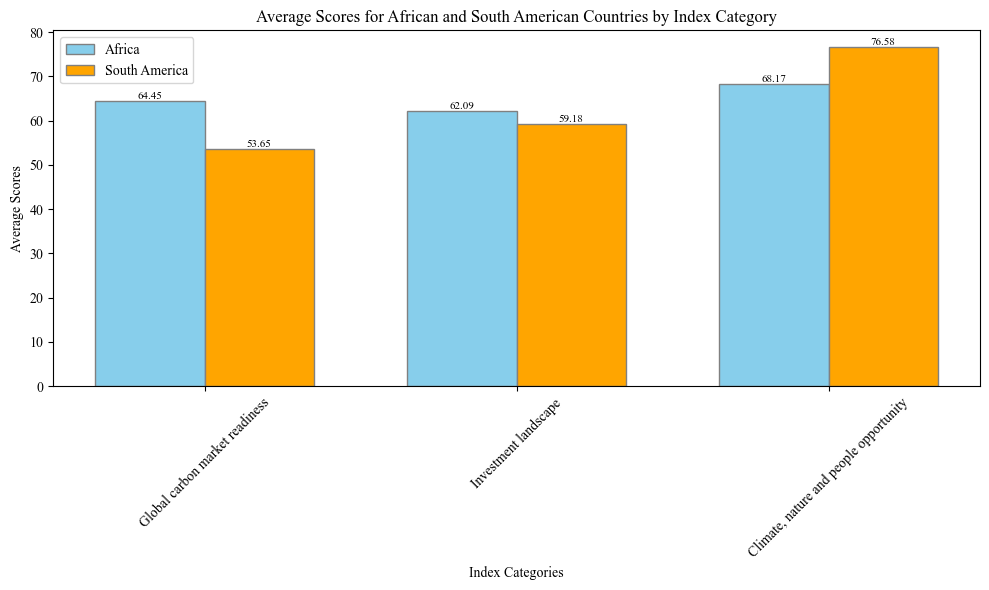

In [72]:
import numpy as np
import matplotlib.pyplot as plt


index_categories = ['Global carbon market readiness', 'Investment landscape', 'Climate, nature and people opportunity']

bar_width = 0.35
# Set the positions for the bars
r1 = np.arange(len(index_categories))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 6))
for i in range(3):
    africa_bars = plt.bar(r1[i], africa_average_scores.iloc[:, i], color='skyblue', width=bar_width, edgecolor='grey', label='Africa')
    south_america_bars = plt.bar(r2[i], south_america_average_scores.iloc[:, i], color='orange', width=bar_width, edgecolor='grey', label='South America')

    # Adding numbers
    for bar in africa_bars + south_america_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom', fontsize=8)

plt.xlabel('Index Categories')
plt.ylabel('Average Scores')
plt.title('Average Scores for African and South American Countries by Index Category')
plt.xticks([r + bar_width/2 for r in range(len(index_categories))], index_categories, rotation=45)
plt.legend(['Africa', 'South America'])
plt.tight_layout()
plt.show()


# **Quantum Prices**

  Voluntary Registry  Mean Unitary Cost
0                ACR         110.678087
1                CAR          17.699949
2               GOLD           2.349677
3                VCS           1.724904


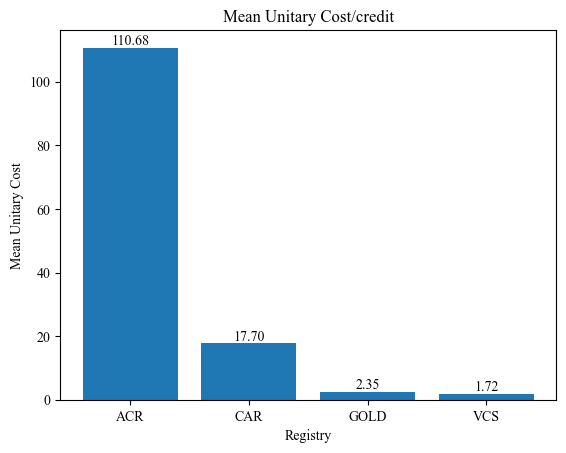

In [38]:
# Assuming you have a DataFrame named 'df' with "Registry" and "unitary_cost" columns
# Group by "Registry" and calculate the mean of "unitary_cost"
mean_unitary_cost_by_registry = data.groupby('Voluntary Registry')['unitary_cost'].mean().reset_index()
mean_unitary_cost_by_registry.columns = ['Voluntary Registry', 'Mean Unitary Cost']

# Print the resulting DataFrame
print(mean_unitary_cost_by_registry)

bars = plt.bar(mean_unitary_cost_by_registry['Voluntary Registry'], mean_unitary_cost_by_registry['Mean Unitary Cost'])
for i, bar in enumerate(bars):
    cost = mean_unitary_cost_by_registry['Mean Unitary Cost'][i]
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{cost:.2f}', ha='center', va='bottom')
plt.xlabel('Registry')
plt.ylabel('Mean Unitary Cost')
plt.title('Mean Unitary Cost/credit')
plt.show()

In [39]:
# Specify the path to your Excel file
excel_file_path = "Costs_Tryout.xlsx"

# Read the Excel file into a pandas DataFrame
df2 = pd.read_excel(excel_file_path)

# Display the first 5 rows of the DataFrame
print(df2.head())

  Project Type  Registry Country  2000  2001  2002  2003  2004  2005  2006   
0   CookStoves       VCS  Africa  3.65  3.65  3.65  3.65  3.65  3.65  3.65  \
1   CookStoves       VCS   India   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2   CookStoves        GS  Africa   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3   CookStoves  Exchange     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4       Corsia  Exchange     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   ...  2016  2017  2018  2019  2020  2021  2022  2023  2024  2025  
0  ...   3.9   3.9  3.90  3.90  3.90  3.90  3.90   3.9  3.90   3.9  
1  ...   3.4   3.4  3.40  3.40  3.40  3.40  3.40   3.4  3.40   3.4  
2  ...   NaN   NaN  4.15  4.55  4.95  5.45  3.45   NaN   NaN   NaN  
3  ...   NaN   NaN   NaN   NaN   NaN   NaN  3.65   NaN   NaN   NaN  
4  ...   NaN   NaN   NaN   NaN   NaN   NaN  0.73   0.7  0.71   NaN  

[5 rows x 29 columns]


In [40]:
no_registry_data = df2[df2['Registry'].isna()]

# Remove rows with no registry from the original DataFrame
df2 = df2.dropna(subset=['Registry'])

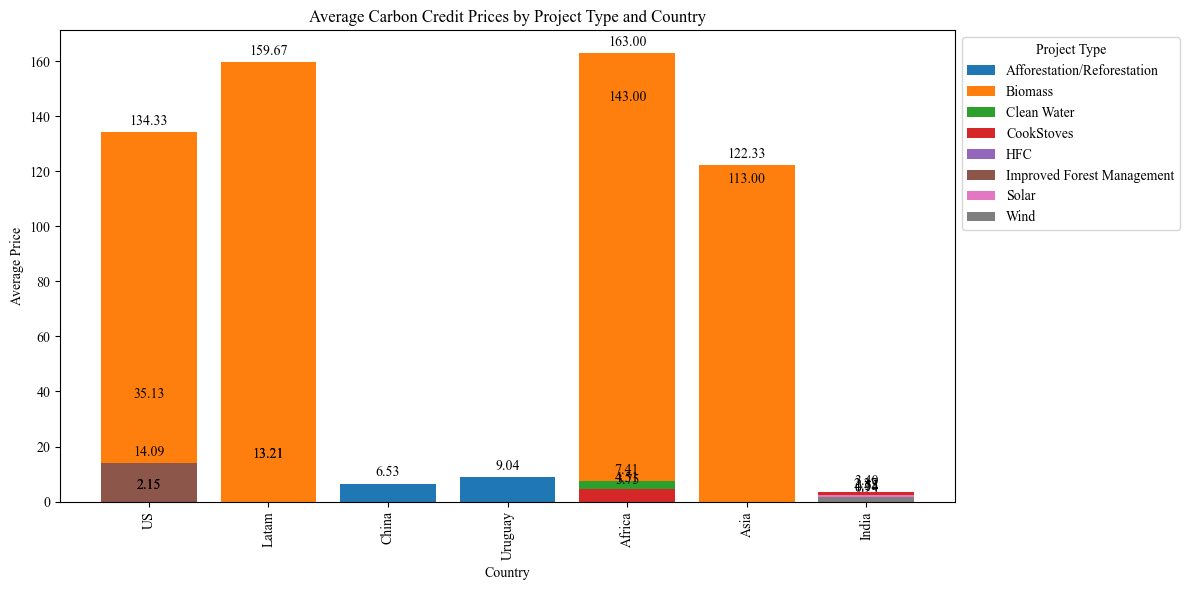

In [41]:
grouped_data = df2.groupby(['Project Type', 'Registry', 'Country']).mean(numeric_only=True)

# Calculate the average price for each scope
average_prices = grouped_data.mean(axis=1).reset_index()
average_prices.columns = ['Project Type', 'Registry', 'Country', 'Average Price']
average_prices_grouped = average_prices.groupby('Project Type')['Average Price'].mean().reset_index()

# Print the average prices


fig, ax = plt.subplots(figsize=(12, 6))
project_types = average_prices_grouped['Project Type'].unique()

for i, project_type in enumerate(project_types):
    project_data = average_prices[average_prices['Project Type'] == project_type]
    x = project_data['Country']
    y = project_data['Average Price']
    bars = ax.bar(x, y, label=project_type)

    # Add numbers on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

ax.set_xlabel('Country')
ax.set_ylabel('Average Price')
ax.set_title('Average Carbon Credit Prices by Project Type and Country')
ax.legend(title='Project Type', bbox_to_anchor=(1, 1))

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

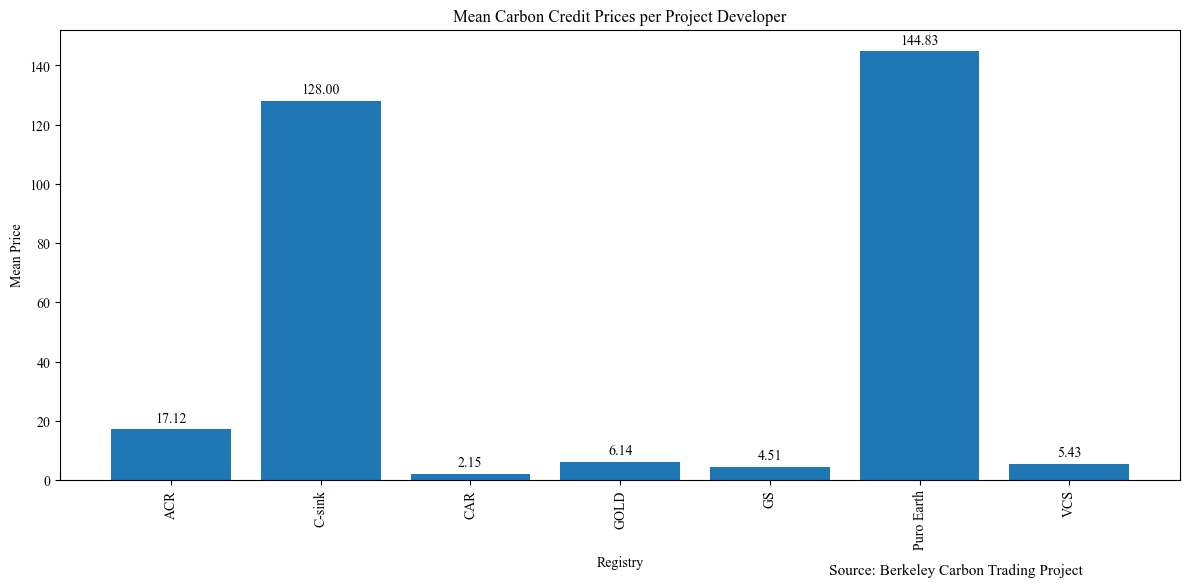

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))

# Group the data by 'Registry' and calculate the mean
mean_prices_per_registry = average_prices.groupby('Registry')['Average Price'].mean().reset_index()
mean_prices_per_registry.columns = ['Registry', 'Mean Price']

# Create the bar chart
x = mean_prices_per_registry['Registry']
y = mean_prices_per_registry['Mean Price']
bars = ax.bar(x, y)

# Add numbers on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

ax.set_xlabel('Registry')
ax.set_ylabel('Mean Price')
ax.set_title('Mean Carbon Credit Prices per Project Developer')
plt.text(0.8, -0.2, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=11)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

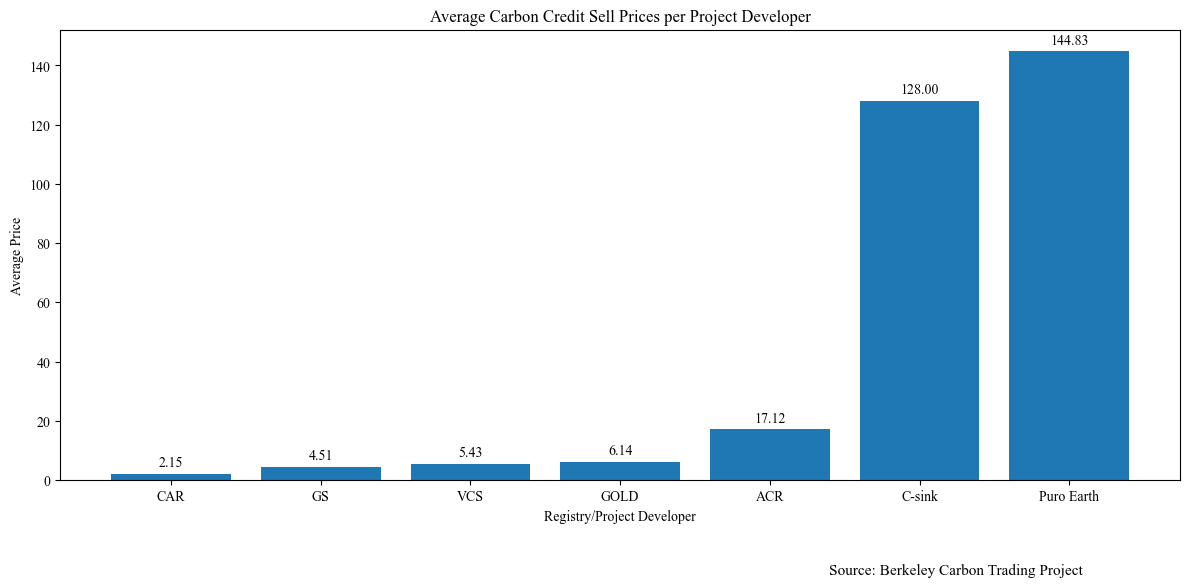

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'average_prices' with columns: 'Registry', 'Average Price'

# Group the data by 'Registry' and calculate the mean
mean_prices_per_registry = average_prices.groupby('Registry')['Average Price'].mean().reset_index()
mean_prices_per_registry.columns = ['Registry', 'Mean Price']

# Sort the DataFrame by 'Mean Price' in descending order
mean_prices_per_registry = mean_prices_per_registry.sort_values(by='Mean Price', ascending=True)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
x = mean_prices_per_registry['Registry']
y = mean_prices_per_registry['Mean Price']
bars = ax.bar(x, y)

# Add numbers on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

ax.set_xlabel('Registry/Project Developer')
ax.set_ylabel('Average Price')
ax.set_title('Average Carbon Credit Sell Prices per Project Developer')
plt.text(0.8, -0.2, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=11)

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


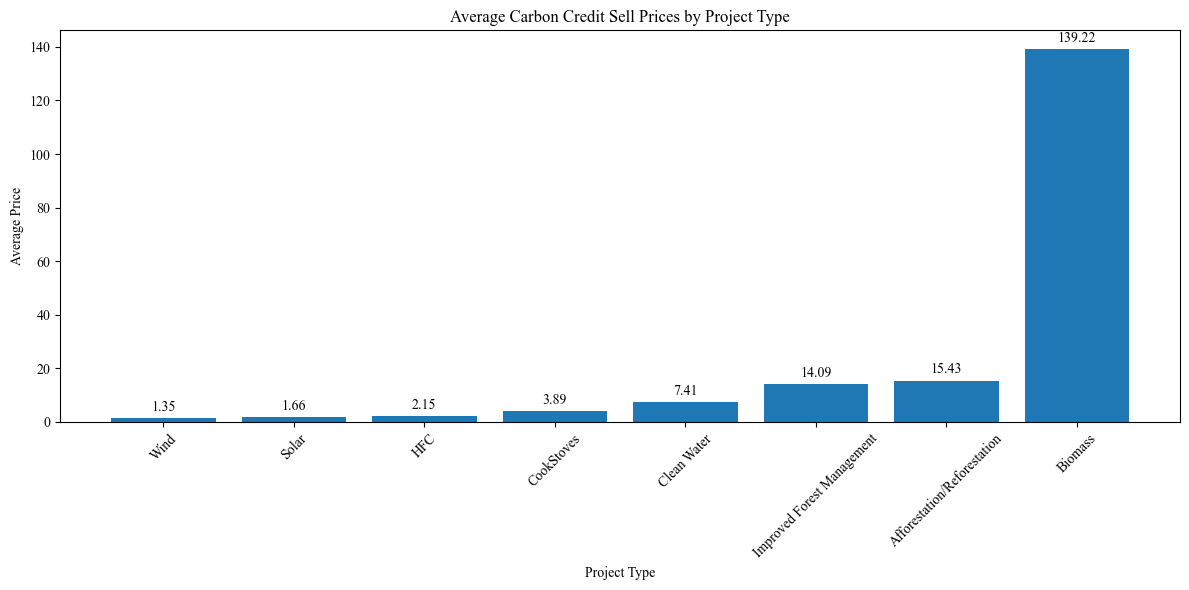

<Figure size 640x480 with 0 Axes>

In [44]:
# Create a bar chart

sorted_average_prices = average_prices_grouped.sort_values(by='Average Price', ascending=True)
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_average_prices['Project Type'], sorted_average_prices['Average Price'])
plt.xlabel('Project Type')
plt.ylabel('Average Price')
plt.title('Average Carbon Credit Sell Prices by Project Type')
plt.xticks(rotation=45)
 
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()
# Show the plot
plt.tight_layout()
plt.show()

In [45]:
# Merge the two DataFrames on the 'Type' and 'Project Type' columns
merged_df_2 = average_cost_by_type.merge(average_prices_grouped, left_on='Type', right_on='Project Type', how='inner')
merged_df_2['Project Development Break Even Cost'] = merged_df_2['Average Price'] - merged_df_2['unitary_cost']

# Print the resulting DataFrame with the new column
print(merged_df_2[['Type', 'Average Price', 'unitary_cost', 'Project Development Break Even Cost']])

# Calculate the difference between 'Average Price' and 'unitary_cost'


                          Type  Average Price  unitary_cost   
0  Afforestation/Reforestation      15.425000      4.457296  \
1                      Biomass     139.222222      1.053509   
2                  Clean Water       7.410000      3.030434   
3                         Wind       1.347357      1.769697   

   Project Development Break Even Cost  
0                            10.967704  
1                           138.168713  
2                             4.379566  
3                            -0.422340  


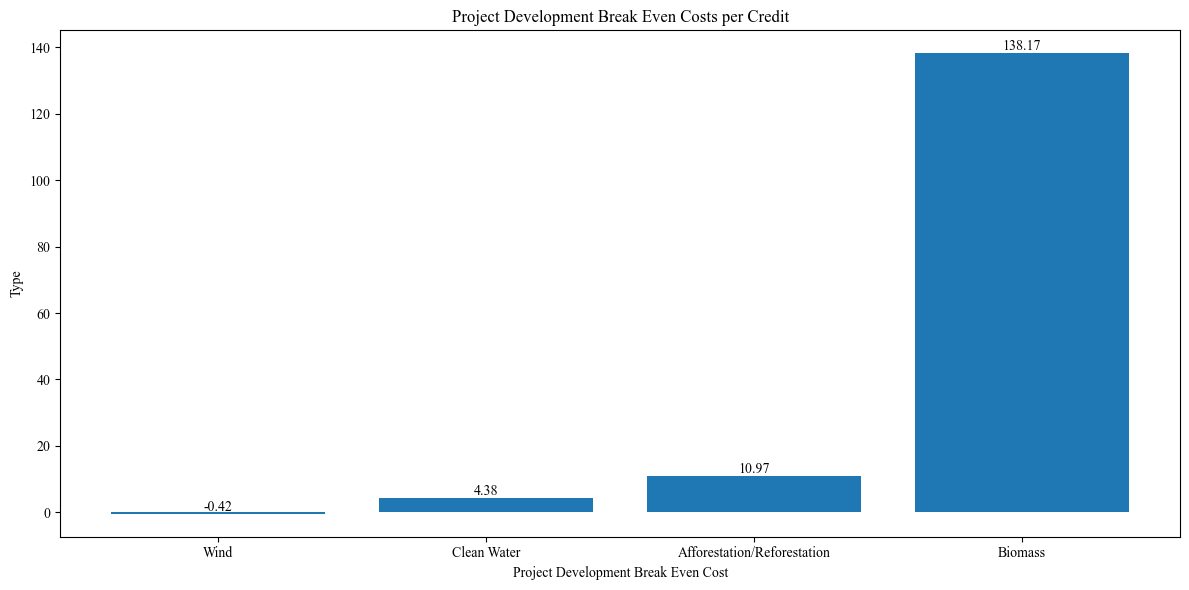

In [46]:
# Sort the DataFrame by 'Project Development Break Even Cost' in descending order
sorted_df = merged_df_2.sort_values(by='Project Development Break Even Cost', ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_df['Type'], sorted_df['Project Development Break Even Cost'])


plt.xlabel('Project Development Break Even Cost')
plt.ylabel('Type')
plt.title('Project Development Break Even Costs per Credit')

# Add values on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')



plt.tight_layout()
plt.show()


In [47]:
verra_projects = no_registry_data.groupby(['Project Type', 'Country']).mean(numeric_only=True)
average_prices2 = verra_projects.mean(axis=1).reset_index()
average_prices2.columns = ['Project Type', 'Country', 'Average Price']
# Assuming you have a DataFrame named 'df' and you want to rename the 'Project Type' column to 'Project ID'
average_prices2= average_prices2.rename(columns={'Project Type': 'Project ID'})
merged_df_3 = data.merge(average_prices2, on='Project ID', how='inner')


In [48]:
# Print the resulting DataFrame
merged_df_3 = data.merge(average_prices2, on='Project ID', how='inner')
merged_df_3['Project Development Break Even Cost'] = merged_df_3['Average Price'] - merged_df_3['unitary_cost']




In [49]:
import matplotlib.pyplot as plt

# Sample data with Project IDs, Break Even Costs, and Countries
project_ids = sorted_df['Project ID']
break_even_costs = sorted_df['Project Development Break Even Cost']
countries = sorted_df['Country_x']

# Create a colormap based on the number of unique countries
colormap = plt.get_cmap("tab10", len(set(countries)))

# Assign a color from the colormap to each country
country_colors = {country: colormap(i) for i, country in enumerate(set(countries))}

# Create a horizontal bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(project_ids, break_even_costs, color=[country_colors[country] for country in countries])
plt.xlabel('Project Development Break Even Cost')
plt.ylabel('Project ID')
plt.title('Project Development Break Even Costs per Credit')

# Add values on the bars
for i, bar in enumerate(bars):
    cost = sorted_df['Project Development Break Even Cost'][i]
    country = countries[i]
    print(cost)
    #plt.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'Cost: {cost:.2f}\nCountry: {countries[i]}', ha='left', va='center')
    #plt.text( cost,  +  bar.get_y(), f'Cost: {cost:.2f}', ha='left', va='center')
# Create a custom legend for each country and its color
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=country, markerfacecolor=color) for country, color in country_colors.items()]
plt.legend(handles=legend_handles, title='Countries')

plt.tight_layout()
plt.show()


KeyError: 'Project ID'

In [ ]:
# Specify the path to your Excel file
excel_file_path = "Livro7.xlsx"

# Read the Excel file into a pandas DataFrame
df3 = pd.read_excel(excel_file_path)

# Display the first 5 rows of the DataFrame
print(df3)

                    Attribute  Transaction Year     Volume  Price
0                      Africa              2016    5410239   $4,1
1                      Africa              2017    4805847   $5,3
2                      Africa              2018   12205659   $4,3
3                      Africa              2019   16143028   $3,9
4                      Africa              2020   16367682   $4,2
5                        Asia              2016   21417582   $1,6
6                        Asia              2017   11419762   $2,3
7                        Asia              2018   24918240   $3,1
8                        Asia              2019   45668703   $1,8
9                        Asia              2020  112652542   $1,2
10                     Europe              2016    2837077   $1,2
11                     Europe              2017     959397   $1,7
12                     Europe              2018    1257758   $4,8
13                     Europe              2019    1148675   $3,1
14        

In [ ]:
data = {
    'Attribute': ['Africa', 'Africa', 'Africa', 'Africa', 'Africa', 'Asia', 'Asia', 'Asia', 'Asia', 'Asia', 'Europe', 'Europe', 'Europe', 'Europe', 'Europe', 'Latin America & Caribbean', 'Latin America & Caribbean', 'Latin America & Caribbean', 'Latin America & Caribbean', 'Latin America & Caribbean', 'North America', 'North America', 'North America', 'North America', 'North America', 'Oceania', 'Oceania', 'Oceania', 'Oceania', 'Oceania'],
    'Transaction Year': [2016, 2017, 2018, 2019, 2020, 2016, 2017, 2018, 2019, 2020, 2016, 2017, 2018, 2019, 2020, 2016, 2017, 2018, 2019, 2020, 2016, 2017, 2018, 2019, 2020, 2016, 2017, 2018, 2019, 2020],
    'Volume': [5410239, 4805847, 12205659, 16143028, 16367682, 21417582, 11419762, 24918240, 45668703, 112652542, 2837077, 959397, 1257758, 1148675, 1989017, 5856715, 7526045, 30155837, 15798829, 23760190, 10077119, 7811750, 11940087, 15580280, 11839893, 545892, 190636, 574457, 450261, 142106],
    'Price': ['$4.1', '$5.3', '$4.3', '$3.9', '$4.2', '$1.6', '$2.3', '$3.1', '$1.8', '$1.2', '$1.2', '$1.7', '$4.8', '$3.1', '$6.1', '$3.8', '$2.7', '$2.3', '$3.5', '$3.8', '$2.9', '$3.5', '$2.9', '$3.6', '$6.2', '$4.9', '$9.4', '$15.1', '$12.5', '$19.0']
}

df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
excel_file = 'data.xlsx'
df.to_excel(excel_file, index=False)

print(f'Data exported to {excel_file}')

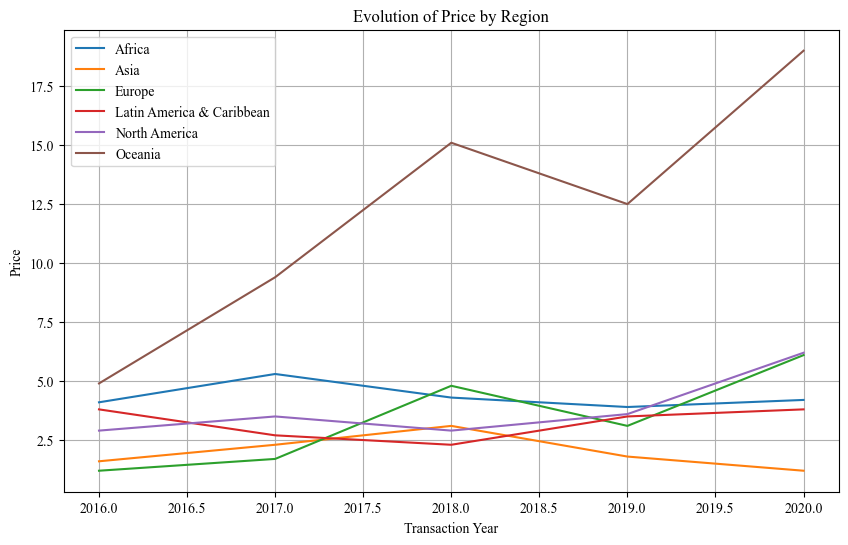

In [ ]:



# Group the data by 'Attribute' and plot the evolution of 'Price'
plt.figure(figsize=(10, 6))
for attribute, data in df3.groupby('Attribute'):
    plt.plot(data['Transaction Year'], data['Price'], label=attribute)

plt.xlabel('Transaction Year')
plt.ylabel('Price')
plt.title('Evolution of Price by Region')
plt.legend()
plt.grid(True)
plt.show()

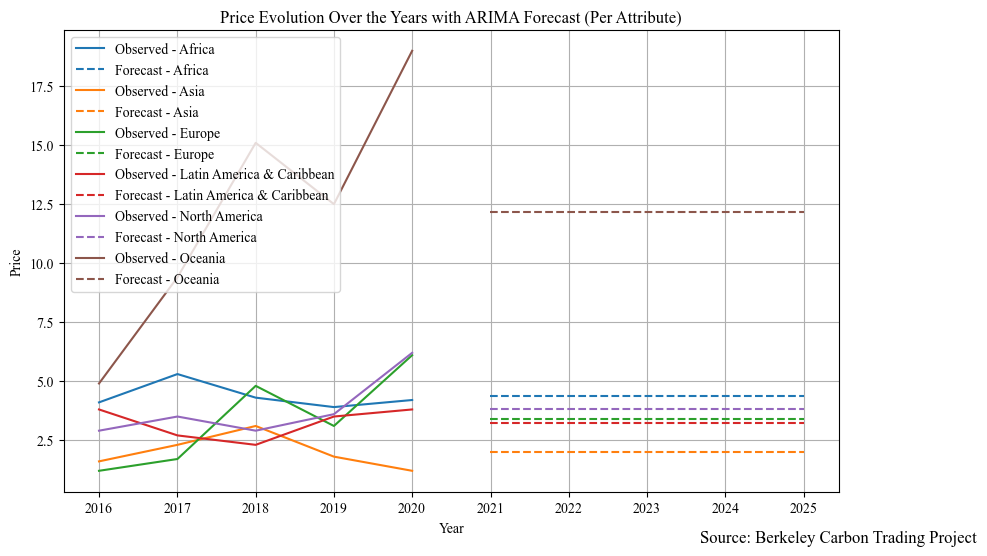

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Get unique attributes (regions) in the DataFrame
attributes = df3['Attribute'].unique()

# Set 'Transaction Year' as the index for the data

# Store a list of unique colors for the attributes
colors = plt.cm.tab10.colors

# Create a dictionary to store the color of each attribute
attribute_colors = {attribute: color for attribute, color in zip(attributes, colors)}

# Define a function to fit ARIMA model and make predictions for a specific attribute (region)
def forecast_attribute(attribute_data):
    # Use auto_arima to automatically select the best ARIMA parameters
    model = auto_arima(attribute_data['Price'], seasonal=False, stepwise=True, suppress_warnings=True)
    
    # Forecast 2 years into the future
    forecast_steps = 5
    forecast, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)
    forecast_index = pd.date_range(attribute_data.index[-1], periods=forecast_steps, freq='Y')
    return forecast_index, forecast

# Iterate through attributes, fit ARIMA model, make predictions, and plot the results
plt.figure(figsize=(10, 6))

for attribute in attributes:
    attribute_data = df3[df3['Attribute'] == attribute]
    forecast_index, forecast_values = forecast_attribute(attribute_data)
    
    # Get the color for the current attribute
    color = attribute_colors[attribute]
    
    # Plot the original data
    plt.plot(attribute_data.index, attribute_data['Price'], label=f'Observed - {attribute}', color=color)
    
    # Plot the forecasted data
    plt.plot(forecast_index, forecast_values, linestyle="--", label=f'Forecast - {attribute}', color=color)

plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Price Evolution Over the Years with ARIMA Forecast (Per Attribute)')
plt.legend()
plt.grid(True)

# Adding the source text
plt.text(1, -0.1, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)
plt.show()
